In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
+ \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
$$

$$
H_I = \hbar \Sigma_x E(t).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|³}.
$$

In [134]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

# ENERGY LANDSCAPE, c = 1, hbar = 1
fixed_lam = 1#2 * np.pi / omega_a                # propto omega_a;  energysplitting of the atom, when ground state is set to 0
omega_a = 2 * np.pi /  fixed_lam  #1.
alpha = 1. # coupling strength of the dipoles       Fine structure const?
# LINBLAD OPS
gamma_0 = .1   # decay rate of the atoms
gamma_phi = .1 # dephasing rate of the atoms

# TOPOLOGY
distance = 1 * fixed_lam # defining topology

# TIME EVOLUTION
last_pulse = 10# * gamma_0
last_det_t = 1 * last_pulse
time_steps = 6
times = np.linspace(0, last_det_t, time_steps) # list of times

def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer
tolerance = count_decimal_digits(times[1]) - 2

In [135]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

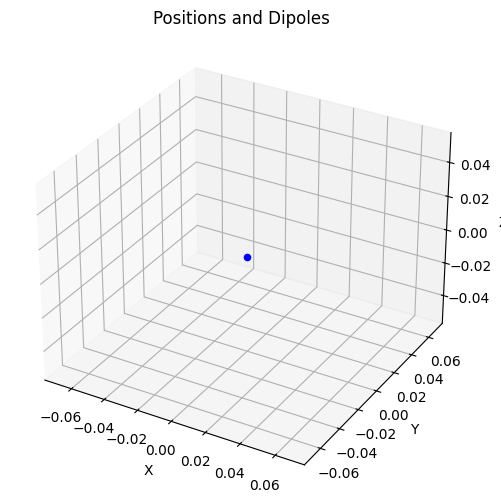

In [136]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [137]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# combined dofs
sm_list = []    # lowering operators of atomic system
S_x = 0         # collective sigma_x operator for the system

for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    S_x += op + op.dag()

mu_0 = S_x # dipole operator at the beginning

In [138]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += omega_a *op # Diagonals except for |0><0|
    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)

H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.        ]
 [0.         6.28318531]]

In [139]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

op_list = sm_list  # Operators combining the cavity (qeye(2)) and the atomic lowering operator (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic ground and excited levels
e_op_list = [
    basis(N_atoms + 1, i) * basis(N_atoms + 1, i).dag()
    for i in range(N_atoms + 1)]

In [229]:

# create the time dependant evolution

I = S_x
E12 = 100 # Amplitude of laser pulses 1,2
E0s = [E12, E12, E12/10] # Probe pulse is smaller
omegas = [omega_a-1, omega_a, omega_a]
Delta_ts = [last_pulse/100, last_pulse/100, last_pulse/100] # narrow width of the pulses
phi12 = 2 * np.pi         # phis = [phi12, phi12, 0]  # Phase-kick?, pulse 1 and 2 are phase locked!

def heaviside(x):
    return 1 if x >= 0 else 0

def El_field(t, tau, T):
    Delta0 = Delta_ts[0]
    Delta1 = Delta_ts[1]
    Delta2 = Delta_ts[2]
    t0 = Delta0

    # Electric field is zero except for the time window t0 - Delta < t < t0 + Delta
    pulse_0 = np.cos(np.pi * (t - t0) / (2 * Delta0))**2
    pulse_0 *= E0s[0] * heaviside(t - (t0 - Delta0)) * heaviside(t0 + Delta0 - t) * np.exp(1j * (omegas[0] * t + phi12))

    # Pulse 1 (from t0 to t0 + Delta)
    pulse_1 = np.cos(np.pi * (t - tau) / (2 * Delta1))**2
    pulse_1 *= E0s[1] * heaviside(t - (tau - Delta1)) * heaviside(tau + Delta1 - t) * np.exp(1j * (omegas[1] * t + phi12))

    # Pulse 1 (from t0 to t0 + Delta)
    pulse_2 = np.cos(np.pi * (t - T) / (2 * Delta2))**2
    pulse_2 *= E0s[2] * heaviside(t - (T - Delta2)) * heaviside(T + Delta2 - t) * np.exp(1j * (omegas[2] * t + 0))

    # Total field: sum of the three pulses
    return (pulse_0 + pulse_1 + pulse_2)


def H_int(t, tau, T):
    return - S_x * El_field(t, tau, T)
def H_tot(t, distance, n_rings, n_chains, args):
    H_0 = Hamilton0(distance, n_rings, n_chains)
    H_int = H_int(t, args)
    return H_0 + H_int


tau, T = 1, 4
H_int = H_int(0.13, tau, T)
H_int

def dip_op_t(t):
    return ((1j * H0 * t).expm()).dag() * S_x * (1j * H0 * t).expm()

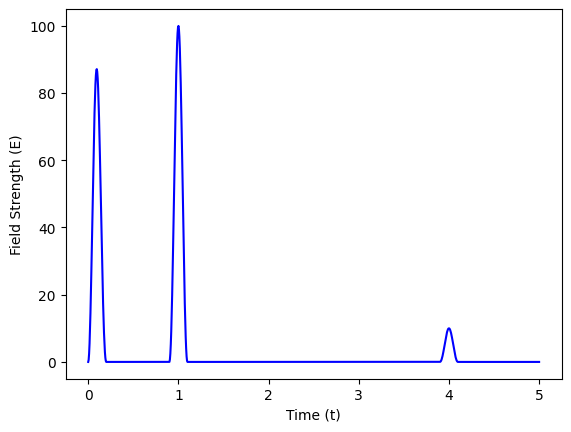

In [204]:
# VIZUALIZE THE FIELD AS AN EXAMPLE
#
t_values = np.linspace(0, 4+ 1, 1000)
tau, T = 1, 4

electric_field = [El_field(t, create_args(tau, T)) for t in t_values]
plt.figure()
plt.plot(t_values, electric_field, label='Electric Field E(t)', color='blue')
plt.xlabel('Time (t)')
plt.ylabel('Field Strength (E)')
plt.show()

In [220]:
# evolution with t
# initial state
psiini = ket2dm(basis(N_atoms+1, 0)) # = |g>_atom
psiini

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [199]:
#
# CALCULATIONS
#

# (third order response)
def S_3(t1, t2, t3):
    d_1 = dip_op_t(t1)
    d_2 = dip_op_t(t1 + t2)
    d_3 = dip_op_t(t1 + t2 + t3)
    C1 = commutator(S_x, psiini)
    C2 = commutator(d_1, C1)
    C3 = commutator(d_2, C2)
    return (1j)**3 * heaviside(t1) * heaviside(t2) * heaviside(t3) * (d_3 * C3).tr()

S_3(0.1, 1, 2)

0j

In [227]:
def mu_3(t, args):
    # Here, we'll calculate the induced dipole moment
    # which can involve using the electric field and S_3.

    # Compute the integral as defined
    integral = 0
    # The three integrals (over t1, t2, t3) should be computed numerically
    for t1 in np.linspace(0, last_pulse, 10):  # Adjust bounds and resolution
        for t2 in np.linspace(0, last_pulse, 10):  # Adjust bounds and resolution
            for t3 in np.linspace(0, last_pulse, 10):  # Adjust bounds and resolution
                # Compute the electric fields at the required times
                E_t3 = El_field(t - t3, args)
                E_t2 = El_field(t - t3 - t2, args)
                E_t1 = El_field(t - t3 - t2 - t1, args)

                # Multiply the electric field components and susceptibility
                integral += S_3(t1, t2, t3) * E_t3 * E_t2 * E_t1
    integral /= (last_pulse**3 * 10**3)  # Scaling by the number of integration steps and pulse duration
    return integral

dipole_moment = mu_3(t, create_args(tau, T))
print(f"Induced dipole moment at time {t}: {dipole_moment}")

Induced dipole moment at time 10.0: 0j


In [219]:
t_values = np.linspace(0, last_pulse, 10)  # Choose the time values for t
T_values = np.linspace(0, last_pulse, 2)  # Choose the time values for T
tau_values = np.linspace(0, last_pulse, 10)  # Choose the time values for tau

# Create a meshgrid for all combinations of t, T, and tau
T_grid, tau_grid, t_grid = np.meshgrid(T_values, tau_values, t_values)

# Flatten the grids to iterate over all combinations
t_grid_flat = t_grid.flatten()
T_grid_flat = T_grid.flatten()
tau_grid_flat = tau_grid.flatten()

# Initialize an array to store the results for each combination of (t, T, tau)
mu_3_values = np.zeros_like(t_grid_flat)

# Iterate over all combinations of t, T, tau
for i in range(len(t_grid_flat)):
    t = t_grid_flat[i]
    T = T_grid_flat[i]
    tau = tau_grid_flat[i]

    # Create the arguments for this combination of t, T, tau
    args = create_args(tau, T)

    # Calculate mu_3 for this combination of t, T, tau
    mu_3_values[i] = mu_3(t, args)

# Now you have the mu_3 values for all combinations of t, T, tau
# You can reshape the results back to the grid shape for easy visualization or further processing
mu_3_grid = mu_3_values.reshape(len(t_values), len(tau_values), len(T_values))

# Example: Print the mu_3 values for the grid of t, T, tau
print("mu_3 values for the grid of t, T, tau:")
for i, t in enumerate(t_values):
    for j, tau in enumerate(tau_values):
        for k, T in enumerate(T_values):
            print(f"mu_3(t={t}, T={T}, tau={tau}) = {mu_3_grid[i, j, k]}")

/tmp/ipykernel_146544/798013846.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  mu_3_values[i] = mu_3(t, args)


mu_3 values for the grid of t, T, tau:
mu_3(t=0.0, T=0.0, tau=0.0) = 0.0
mu_3(t=0.0, T=10.0, tau=0.0) = 7.357552708582411
mu_3(t=0.0, T=0.0, tau=1.1111111111111112) = 16.069524127502824
mu_3(t=0.0, T=10.0, tau=1.1111111111111112) = 17.262386614297352
mu_3(t=0.0, T=0.0, tau=2.2222222222222223) = 10.377986554205023
mu_3(t=0.0, T=10.0, tau=2.2222222222222223) = -1.3623887530728243
mu_3(t=0.0, T=0.0, tau=3.3333333333333335) = -12.465287221523624
mu_3(t=0.0, T=10.0, tau=3.3333333333333335) = -17.73553926278725
mu_3(t=0.0, T=0.0, tau=4.444444444444445) = -14.707135374429747
mu_3(t=0.0, T=10.0, tau=4.444444444444445) = -4.797099392773868
mu_3(t=0.0, T=0.0, tau=5.555555555555555) = 0.0
mu_3(t=0.0, T=10.0, tau=5.555555555555555) = 5.563737729353403
mu_3(t=0.0, T=0.0, tau=6.666666666666667) = 12.463872823512562
mu_3(t=0.0, T=10.0, tau=6.666666666666667) = 13.532023303033487
mu_3(t=0.0, T=0.0, tau=7.777777777777779) = 8.268389687378088
mu_3(t=0.0, T=10.0, tau=7.777777777777779) = -0.8641153559169

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_146544/87299826.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'$\mu_3$ for T={T}')
/tmp/ipykernel_146544/87299826.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f'Fourier Transform of $\mu_3$ for T={T}')


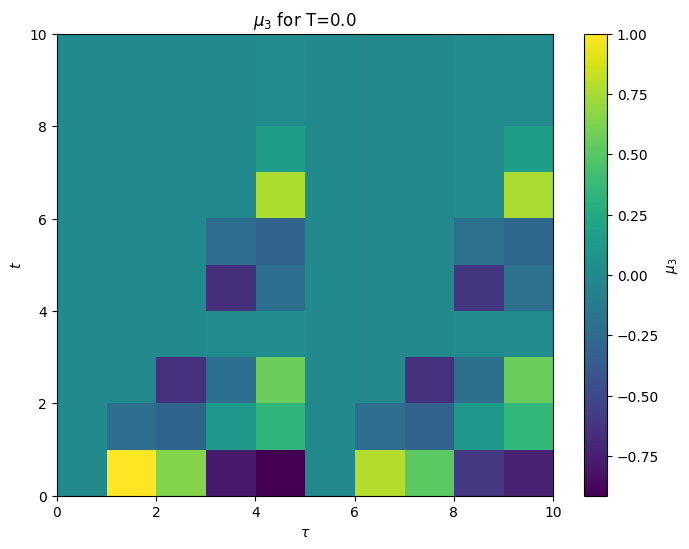

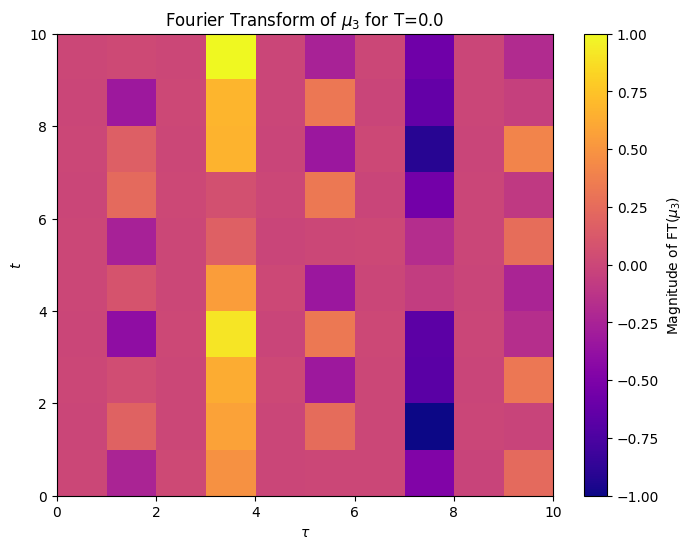

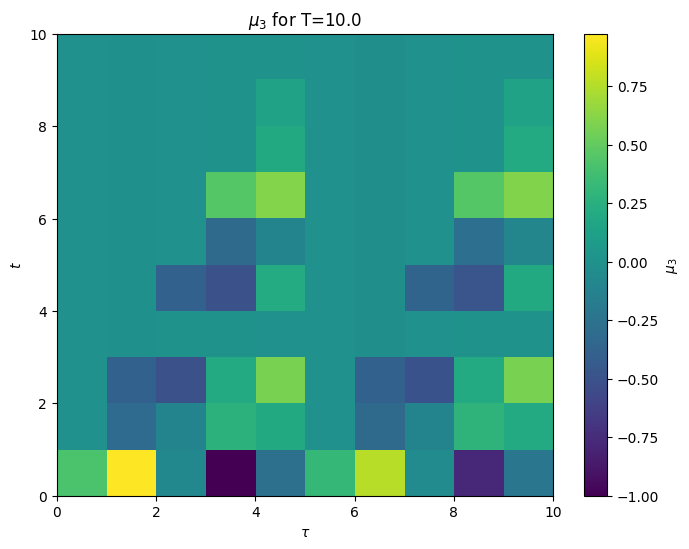

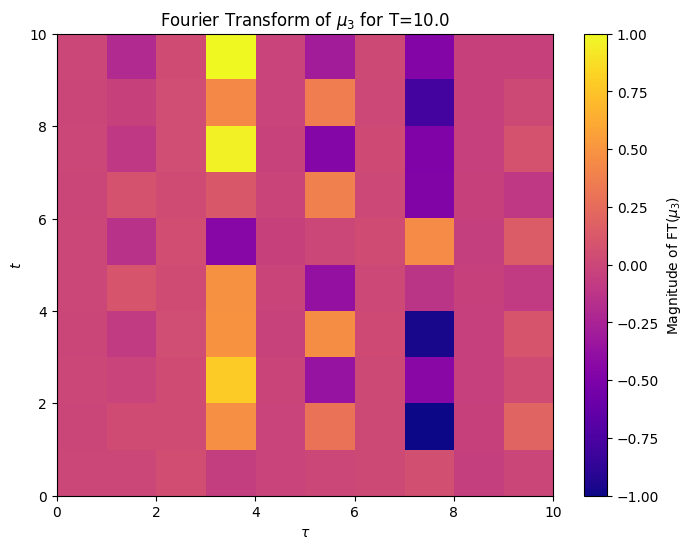

In [226]:
# Plotting the data for each T value in 2D (dependant on tau and t)
for k, T in enumerate(T_values):
    data = mu_3_grid[:, :, k]
    data /= np.max(np.abs(data))
    plt.figure(figsize=(8, 6))
    plt.imshow(data, extent=[tau_values[0], tau_values[-1], t_values[0], t_values[-1]], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label=r'$\mu_3$')
    plt.title(f'$\mu_3$ for T={T}')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$t$')
    plt.show()

    # Fourier Transform of the data for this T
    mu_3_ft = np.fft.fft2(data)
    mu_3_ft_shifted = np.fft.fftshift(mu_3_ft)  # Shift zero frequency to the center

    # Plot the magnitude of the Fourier Transform
    magnitude = np.imag(mu_3_ft_shifted)
    magnitude /= np.max(np.abs(magnitude))
    plt.figure(figsize=(8, 6))
    plt.imshow(magnitude, extent=[tau_values[0], tau_values[-1], t_values[0], t_values[-1]], origin='lower', aspect='auto', cmap='plasma')
    plt.colorbar(label=r'Magnitude of FT($\mu_3$)')
    plt.title(f'Fourier Transform of $\mu_3$ for T={T}')
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$t$')
    plt.show()